In [1]:
## Download data

suppressMessages(library(tidyverse))
suppressMessages(library(lme4))
suppressMessages(library(lmerTest))
suppressMessages(library(ggridges))


## Download Illumina data
df_mcnv3_illum <- read_csv("../data/Illumina_nofilter_mCNVs.csv")
if(colnames(df_mcnv3_illum)[2] == "COMPUTED_GENDER"){
  colnames(df_mcnv3_illum)[2] = "SEX"
}## Download Affy data

df_mcnv3_affy <- read_csv("..//data/Affy6_nofilter_mCNVs.csv")

if(colnames(df_mcnv3_affy)[2] == "COMPUTED_GENDER"){
  colnames(df_mcnv3_affy)[2] = "SEX"
}


## Merge
df_mcnv3 = rbind(df_mcnv3_illum %>% dplyr::select(-c(CALL_RATE)), df_mcnv3_affy)




Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
Rows: 28052 Columns: 50
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (13): SAMPLE, COMPUTED_GENDER, CHROM, P_ARM, Q_ARM, TYPE, batch, arrayNa...
dbl (37): BEG_GRCh37, END_GRCh37, LENGTH, N_SITES, NHETS, N50_HETS, BDEV, BD...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 18407 Columns: 49
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (13): SAMPLE, COMPUTED_GENDER, CHROM, P_ARM, Q_ARM, TYPE, batch, arrayNa...
dbl (36): BEG_GRCh37, END_GRCh37, LENGTH, N_SITES, NHETS, N50_HETS, BDEV, BD...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or 

In [2]:
nhets=20
overlap_control = 0.50
overlap_1kg = 0.50
overlap_pgc = 0.50
baf_cutoff = 0.10


df_mosaic0 <- df_mcnv3 %>% mutate(CHROM = trimws(CHROM)) %>%
  filter(CHROM != "X") %>%
  mutate(batch = str_replace(string=.$batch,pattern="_1|_3",replacement = "")) %>% 
  mutate(batch = str_replace(string=.$batch,pattern="_eur-qc",replacement = "")) %>%
  filter(OVRLP_CONTROL < overlap_control) %>% 
  filter(!(OVRLP_PGC > overlap_pgc & RETYPE == "DUP")) %>%
  filter(!(RETYPE == "DUP" & BDEV > baf_cutoff)) %>% 
  filter(label != "non-SCZ")  %>% mutate(low_qual = (LOD_BAF_PHASE < 10)) %>% filter(!low_qual) %>% filter(RETYPE!="UKN")
# %>% filter(Posterior > 0.95)

compute_CF <- function(BDEV, TYPE){
  ## Function to impute CF
  if (TYPE == "DUP"){
    CF = 2*BDEV/(0.5 - BDEV)
  } else if (TYPE== "DEL"){
    CF = 2*BDEV/(0.5 + BDEV)
  } else if (TYPE == "CNN-LOH"){
    CF = 2*BDEV
  } else{
    return("Type needs to be DUP, DEL, or CN-LOH")
  }
  return(CF)
}

for (i in 1:nrow(df_mosaic0)){
  if(is.na(df_mosaic0$CF[i])){
    df_mosaic0$CF[i] = compute_CF(df_mosaic0$BDEV[i], df_mosaic0$RETYPE[i])
  }
}

## FIltering out residual germline events
df_mosaic0 <- df_mosaic0 %>% filter(!(CHROM == "7" & BEG_GRCh37 == 0 & END_GRCh37 == 68920) &  
                        !(CHROM == "20" & BEG_GRCh37 == 59569516 & END_GRCh37 == 59589272))

df_mosaic0 = df_mosaic0 %>% filter(!(RETYPE=="DEL" & LDEV < -0.5 & arrayName == "Affy6"))
df_mosaic0 = df_mosaic0 %>% filter(!(batch %in% c("GAIN","Gejman.MGS","scz_lacw_lemu_eur_qc"))) ## these batches were come cell lines. 

n_dx = 12834
n_ctrl = 11648

cat("No filtering")
nrow(df_mosaic0)
df_counts_total <- df_mosaic0  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% 
                        summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_ctrl,n_dx))
head(df_counts_total)

fisher.test(matrix(c(df_counts_total$burden[2],n_dx-df_counts_total$burden[2],
                     df_counts_total$burden[1],n_ctrl-df_counts_total$burden[1]), ncol=2, byrow = TRUE),
            alternative = "two.sided")


df_mosaic = df_mosaic0 %>% filter( !(CHROM == "6" & BEG_GRCh37 > 1.9e7 & END_GRCh37 < 5e7) &
                                     !(CHROM == "14" & BEG_GRCh37 >105e6 & END_GRCh37 <108e6) &
                                     !(CHROM == "22" & BEG_GRCh37 > 2.2e7 & END_GRCh37 < 2.4e7) ) %>% filter(FailedQC == 0)


cat("MHC filtering\n")
nrow(df_mosaic)
df_counts_total <- df_mosaic  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% 
                        summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_ctrl,n_dx))
head(df_counts_total)

fisher.test(matrix(c(df_counts_total$burden[2],n_dx-df_counts_total$burden[2],
                     df_counts_total$burden[1],n_ctrl-df_counts_total$burden[1]), ncol=2, byrow = TRUE),
            alternative = "two.sided")

df_mosaic_loh = df_mosaic %>% filter(RETYPE!="CNN-LOH")
cat("LOH filtering\n")
nrow(df_mosaic_loh)
df_counts_total <- df_mosaic_loh  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% 
                        summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_ctrl,n_dx))
head(df_counts_total)

fisher.test(matrix(c(df_counts_total$burden[2],n_dx-df_counts_total$burden[2],
                     df_counts_total$burden[1],n_ctrl-df_counts_total$burden[1]), ncol=2, byrow = TRUE),
            alternative = "two.sided")

cat("Loci filtering\n")
df_mosaic_loci = df_mosaic_loh %>% filter(CF < 1) %>% filter(!(grepl("20q11",CYTOBAND) & RETYPE =="DEL")) %>%
  filter(!(grepl("DNMT3A|DNMT3A,|,DNMT3A",GENES) & RETYPE=="DEL")) %>%
  filter(!(grepl(",TET2|,TET2",GENES) & RETYPE == "DEL")) %>% 
  filter(!(grepl("^13q14", CYTOBAND) & RETYPE == "DEL")) %>% 
  filter(!(grepl("17p", CYTOBAND) & RETYPE =="DEL")) %>%
  filter(!(grepl("^5q14", CYTOBAND) & RETYPE =="DEL")) %>%
  filter(!(grepl(",ATM|ATM,", GENES) & RETYPE =="DEL")) %>%
  filter(!(grepl("15q", CYTOBAND) & RETYPE == "DUP")) %>%
  filter(RETYPE != "CNN-LOH" ) %>% filter(!(grepl("7q34", CYTOBAND))) %>% filter(!(grepl("14q11.2", CYTOBAND))) %>%
  filter(!(CHROM== "12" & P_ARM == "T" & Q_ARM == "T"))

nrow(df_mosaic_loci)
df_counts_total <- df_mosaic_loci  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% 
                        summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_ctrl,n_dx))
head(df_counts_total)

fisher.test(matrix(c(df_counts_total$burden[2],n_dx-df_counts_total$burden[2],
                     df_counts_total$burden[1],n_ctrl-df_counts_total$burden[1]), ncol=2, byrow = TRUE),
            alternative = "two.sided")


cat("Sample filtering\n")
many_calls = df_mosaic_loci %>% group_by(SAMPLE) %>% summarise(n=n())  %>% filter(n > 5)
df_mosaic_final <- df_mosaic_loci %>%  filter(!(SAMPLE %in% many_calls$SAMPLE)) 
nrow(df_mosaic_final)

df_counts_total <- df_mosaic_final  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% 
                        summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_ctrl,n_dx))
head(df_counts_total)

fisher.test(matrix(c(df_counts_total$burden[2],n_dx-df_counts_total$burden[2],
                     df_counts_total$burden[1],n_ctrl-df_counts_total$burden[1]), ncol=2, byrow = TRUE),
            alternative = "two.sided")


No filtering

[1] 1341

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,567,0.04867788
SCZ,543,0.04230949



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_dx - df_counts_total$burden[2], df_counts_total$burden[1], n_ctrl - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.01784
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.7639459 0.9757263
sample estimates:
odds ratio 
 0.8633994 


MHC filtering


[1] 1185

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,498,0.04275412
SCZ,503,0.03919277



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_dx - df_counts_total$burden[2], df_counts_total$burden[1], n_ctrl - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.1647
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8031163 1.0386446
sample estimates:
odds ratio 
 0.9133075 


LOH filtering


[1] 320

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,99,0.008499313
SCZ,166,0.012934393



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_dx - df_counts_total$burden[2], df_counts_total$burden[1], n_ctrl - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.0008181
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.183100 1.983619
sample estimates:
odds ratio 
  1.528622 


Loci filtering


[1] 224

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,61,0.005236951
SCZ,120,0.009350164



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_dx - df_counts_total$burden[2], df_counts_total$burden[1], n_ctrl - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.0001744
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.305165 2.484427
sample estimates:
odds ratio 
  1.792786 


Sample filtering


[1] 198

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,60,0.005151099
SCZ,118,0.009194328



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_dx - df_counts_total$burden[2], df_counts_total$burden[1], n_ctrl - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.0002069
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 1.301195 2.490666
sample estimates:
odds ratio 
  1.792161 


In [3]:
1341 - 198

[1] 1143

In [4]:
# df_tmp = df_mosaic_final %>% dplyr::select(-c("low_qual"))
# df_chip = anti_join(df_mosaic0, df_tmp)

pacman::p_load("VariantAnnotation","plyranges","rtracklayer",
              "Biostrings","liftOver")

cannonical_chip = read_tsv("../data/chromosome_positions_common_CHIP_CNAs_grch38_with_type_CNV.txt")
colnames(cannonical_chip) =  c("Idf","seqnames","start","end","LENGTH","TYPE")
## Convert from hg38 to hg19

cannonical_chip = cannonical_chip %>% mutate(cyto = Idf, seqnames = paste0("chr",seqnames)) %>%
    dplyr::select(-c(Idf)) %>% as_granges() %>%  mutate(TYPE = ifelse(TYPE == "Amp","DUP","DEL"))

path = system.file(package="liftOver", "extdata", "hg38ToHg19.over.chain")
ch = import.chain(path)
ch

chip_hg19 = liftOver(cannonical_chip, ch)
chip_hg19 = unlist(chip_hg19)
genome(chip_hg19) = "hg19"

df_chip_ = df_mosaic0 %>% filter(CF < 1) %>% dplyr::select(c("CHROM","BEG_GRCh37","END_GRCh37","LENGTH","CF","RETYPE",
                                                           "SAMPLE","batch","arrayName", "label")) 
colnames(df_chip_) = c("seqnames","start","end","LENGTH","CF","TYPE", "SAMPLE","batch","arrayName","label")
df_chip_ = df_chip_ %>% as_granges() 
seqlevelsStyle(df_chip_) = "UCSC"
genome(df_chip_) = "hg19"
df_chip_dup = df_chip_ %>% filter(TYPE == "DUP") %>% filter_by_overlaps(chip_hg19 %>% filter(TYPE == "DUP")) %>% as.data.frame()
df_chip_del = df_chip_ %>% filter(TYPE == "DEL") %>% filter_by_overlaps(chip_hg19 %>% filter(TYPE == "DEL")) %>% as.data.frame()
df_chip = rbind(df_chip_dup, df_chip_del)



pacman::p_unload("VariantAnnotation","plyranges","rtracklayer",
              "Biostrings","liftOver")


## number of events filtered as chip
nrow(df_chip)

df_counts_total <- df_chip  %>% group_by(label) %>% distinct(SAMPLE,.keep_all = TRUE) %>% 
                        summarise(burden=n()) %>% ungroup() %>% mutate(burden_fraction = burden/c(n_ctrl,n_dx))
head(df_counts_total)

fisher.test(matrix(c(df_counts_total$burden[2],n_dx-df_counts_total$burden[2],
                     df_counts_total$burden[1],n_ctrl-df_counts_total$burden[1]), ncol=2, byrow = TRUE),
            alternative = "two.sided")

Rows: 22 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): Idf, Type
dbl (4): Chrom, Start, End, Length

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Chain of length 25
names(25): chr22 chr21 chr19 chr20 chrY chr18 ... chr6 chr5 chr4 chr3 chr2 chr1

The following packages have been unloaded:
VariantAnnotation, plyranges, rtracklayer, Biostrings, liftOver




[1] 238

label,burden,burden_fraction
<chr>,<int>,<dbl>
ctrl,88,0.007554945
SCZ,105,0.008181393



	Fisher's Exact Test for Count Data

data:  matrix(c(df_counts_total$burden[2], n_dx - df_counts_total$burden[2], df_counts_total$burden[1], n_ctrl - df_counts_total$burden[1]), ncol = 2, byrow = TRUE)
p-value = 0.6128
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.8075307 1.4569512
sample estimates:
odds ratio 
  1.083635 


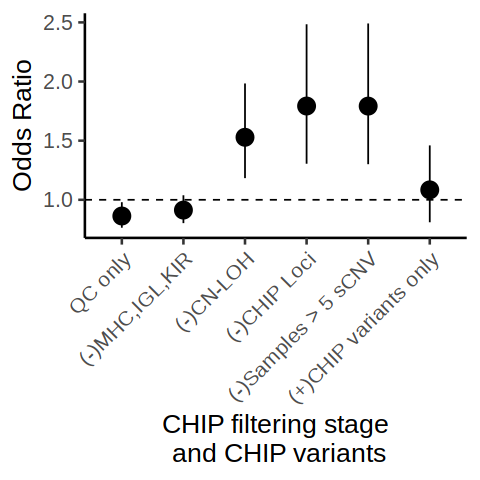

In [6]:
df_plot = data.frame(filter_stage = c("QC only","(-)MHC,IGL,KIR","(-)CN-LOH","(-)CHIP Loci","(-)Samples > 5 sCNV",
                                     "(+)CHIP variants only"),
                    OR= c(0.863,0.913, 1.5286,1.7928,1.792161,1.084), low_ci = c(0.764,0.803,1.1831,1.305,1.3011,0.81), 
                     high_ci=c(0.98,1.0386,1.9836,2.484,2.4907,1.46))

options(repr.plot.width=4, repr.plot.height=4)
p1= df_plot %>% mutate(filter_stage = factor(filter_stage,
                                         levels=c("QC only","(-)MHC,IGL,KIR","(-)CN-LOH","(-)CHIP Loci","(-)Samples > 5 sCNV",
                                                 "(+)CHIP variants only"))) %>%
    ggplot(aes(x=filter_stage,y=OR)) + geom_pointrange(aes(ymin=low_ci,ymax=high_ci), size=1)+
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2) + theme(axis.text.x = element_text(angle=45, vjust=1, hjust=1)) +
    labs(x="CHIP filtering stage\n and CHIP variants",y= "Odds Ratio")


p1

ggsave("../OR_chip_filtering.pdf",p1,device="pdf",width=4,height=4)


In [7]:
df_plot

filter_stage,OR,low_ci,high_ci
<chr>,<dbl>,<dbl>,<dbl>
QC only,0.863000,0.7640,0.9800
"(-)MHC,IGL,KIR",0.913000,0.8030,1.0386
(-)CN-LOH,1.528600,1.1831,1.9836
(-)CHIP Loci,1.792800,1.3050,2.4840
(-)Samples > 5 sCNV,1.792161,1.3011,2.4907
(+)CHIP variants only,1.084000,0.8100,1.4600
